<span style="font-family: Palatino; font-size: 34px; color:purple">
    Homework 3: How much should you pay for this fraud-detection model?
</span>

Copyright (c) 2022 RM Stein

This version: 9-30-2022

In [233]:
from datetime import datetime, date
import copy as cp
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

import statsmodels.formula.api as sm


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix



# DATA_PATH = "./data/"
DATA_FN   = "cc_transactions.csv"
TODAY = date.today()

In this home work, you will get some experience working assessing the financial value of models that you build. 


#  <span style="font-family: Palatino; font-size: 30px; color:purple">Business context </span>

We have been asked by the CSO (Chief  Security Officer), Xufeng, at MasterVista, a credit card company, to develop a fraud detection model to spot credit card transactions that may be suspicious.  MasterVista is concerned that some fraud-detection systems are not practical as they either cost too much to run or are difficult to explain to senior management and regulators.

Therefore, in addition to developing two models for predicting the probability that a prospective transaction is fraudulent, you will need to determine the value of each model, so that Xufeng can determine whether which model to recommend to the the Senior Management team.

# Helper functions

In [234]:
def calc_age(birthday):
    #birthday = datetime.strptime(bdate, "%Y/%m/%d").date()
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))


#  <span style="font-family: Palatino; font-size: 30px; color:purple">The data </span>

The data can be found in the file `cc_tranactions.csv`.  

The dataset contains individual credit card transactions over a the period 01-01-2019 - 12-31-2021.  The transactions only represent a small subset of all users that we have sampled to keep the size of the dataset manageable.  The data dictionary is given below.

The data set contains 1,997,859 observations of 26 variables per transaction.

_(Note that for purposes of this home work, the data are synthetic, but based on a real data set.  We do this to avoid privacy issues.  Also note that we are making some simplifying assumptions about the costs and benefits of transactions, etc.)_

## Data Dictionary

 | __variable__   | __Description__ |
 | :--            | -:-             |
 | ` ssn `        | Social Security number 
 | ` cc_num `     | Credit card number 
 | ` first `      | First name
 | ` last `       | Last name
 | ` gender `     | Gender
 | ` street `     | Street address
 | ` city `       | City of residence
 | ` state `      | State of residence
 | ` zip `        | Postal code of residence
 | ` lat `        | Latitude of residence
 | ` long `       | Longitude of residence
 | ` city_pop   ` | Population of city of residence
 | ` job `        | Job title
 | ` dob `        | Date of birth
 | ` acct_num `   | User acct number
 | ` profile `    | Demographic cluster
 | ` trans_num `  | Transaction number
 | ` trans_date ` | Transaction date
 | ` trans_time ` | Transaction time
 | ` unix_time `  | UNIX time of transaction
 | ` category `   | Type of product
 | ` amt `        | Transaction amt
 | ` is_fraud `   | Dummy indicating fraud (1) or no-fraud (0)
 | ` merchant `   | Name of merchant executing transaction
 | ` merch_lat `  | Latitude of merchant location
 | ` merch_long ` | Longitude of merchant location
 

## Selected data summaries

### `is_fraud`

| __label__   | __count__ 
| :--   | :-- |    
| 0  |  1,990,508
| 1  |    7,351

### `profile`

 | __label__   | __count__ 
 | :--   | :-- |    
adults_2550_female_rural |  19738
adults_2550_female_urban | 573037
adults_2550_male_rural |    21969
adults_2550_male_urban |   497764
adults_50up_female_rural |   8756
adults_50up_female_urban | 299042
adults_50up_male_rural |    20862
adults_50up_male_urban |   303322
young_adults_female_rural |  7686
young_adults_female_urban    119580
young_adults_male_rural |    6577
young_adults_male_urban |  119526

### `category`

 | __Label__   | __count__ 
 | :--   | :-- |  
entertainment | 145896
food_dining |   150670
gas_transport | 170316
grocery_net |    86063
grocery_pos |   187250
health_fitness  |   124189
home |       186835
kids_pets |     174024
misc_net |    90653
misc_pos |   131483
personal_care | 141152
shopping_net |  146755
shopping_pos |  198182
travel |      64391

## Load the data


In [235]:
data = pd.read_csv(DATA_FN)

# <span style="font-family: Palatino; font-size: 24px; color:purple">Model building </span>

## Preprocessing

### For each record, calculate the age of the customer based on `dob` and the day of the week of the transaction.

In [237]:
dob = pd.to_datetime(data["dob"])

In [238]:
trans_date =pd.to_datetime(data['trans_date'])
age_in_years = (trans_date - dob)/365

In [239]:
data["age"] = age_in_years.dt.days

### Perform any other preprocessing you think appropriate
(Be sure to note whether you are "peeking" at the test data (see below)  in those cases, you may need to split the data _before_ doing some preprocessing steps.)

In [240]:
data["sex"] = data["gender"].apply(lambda x: 1 if x == 'M' else 0)

In [241]:
data['dow'] = pd.to_datetime(data['trans_date']).dt.dayofweek


### Split the data into training and test samples.  
The test sample should include records with index 1,500,000 through end of the data.

In [242]:
train = data[:1500000]
test = data[1500000:]

## The current (incumbent) model
MasterVista has a model that was developed by an analyst at the bank.  The model is a linear one with the following form:

$$ y = logit(log(age)+log(city_pop)+dow $$

### Estimate the MasterVista model on your training data. Use the test data to plot the ROC and calculate the ROC AUC

In [244]:
MasterVista_model = sm.logit(formula = 'is_fraud ~ np.log(age) + np.log(city_pop) + dow', data = train).fit()


Optimization terminated successfully.
         Current function value: 0.022918
         Iterations 10


In [230]:
dependent = test['is_fraud']

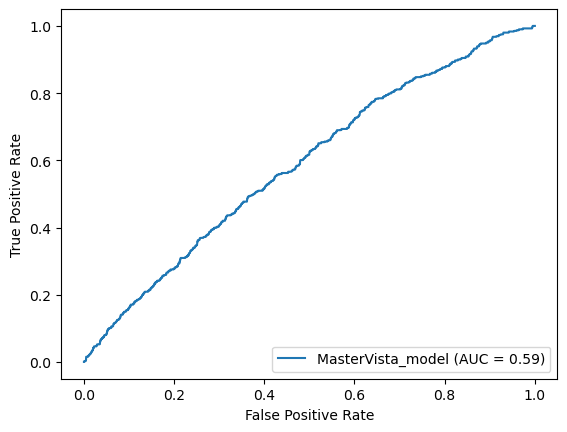

0.5882120095722705


In [250]:
y = MasterVista_model.predict(test)
fpr, tpr, thresholds = metrics.roc_curve(dependent, y)
roc_auc_scores1 = roc_auc_score(dependent, y_score=y)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MasterVista_model')
display.plot()
plt.show()
print(roc_auc_scores1)

### Build your own GAM (with logit link function) to predict `is_fraud`.  Can you do better than MasterVista?
Only use the training data to build the model.  Use the test data to plot the ROC and calculate the ROC AUC.

In [252]:

GAM_model = sm.logit(formula = 'is_fraud ~ np.log(age) + np.log(city_pop) + dow + amt + sex', data = train).fit()





Optimization terminated successfully.
         Current function value: 0.021523
         Iterations 10


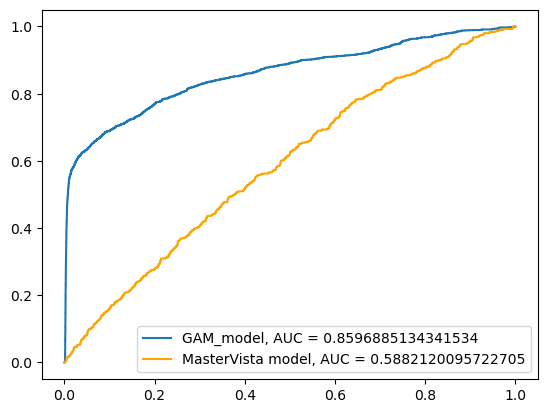

0.8596885134341534


In [305]:
GAM_model_predict = GAM_model.predict(test)
fpr2, tpr2, thresholds2 = metrics.roc_curve(dependent, GAM_model_predict)
roc_auc_scores2 = roc_auc_score(y_true=dependent, y_score=GAM_model_predict)
plt.plot(fpr2, tpr2, label=f'GAM_model, AUC = {roc_auc_scores2}')
plt.plot(fpr, tpr, label=f'MasterVista model, AUC = {roc_auc_scores1}', color = 'orange')
plt.legend()
plt.show()
print(roc_auc_scores2)

## Now build a tree model to predict `is_fraud`.  Can you beat your GAM?
Only use the training data to build the model.  Use the test data to plot the ROC and calculate the ROC AUC.

In [290]:
list_variables = ['age', 'city_pop', 'dow', 'amt', 'sex']

tree = DecisionTreeClassifier()
tree.fit(train[list_variables], train['is_fraud'])
y_vars = test[list_variables]

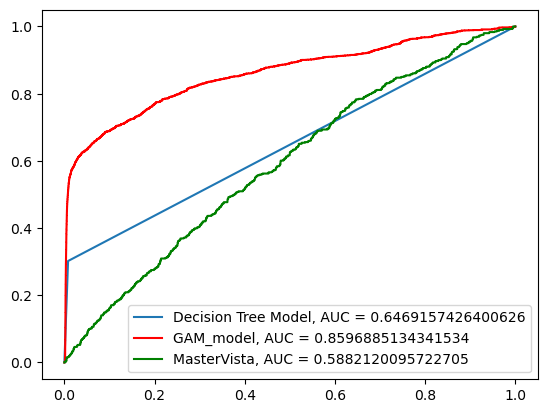

0.6469157426400626


In [318]:
tree_y = tree.predict(y_vars)
fpr3, tpr3, thresholds3 = roc_curve(dependent, tree_y)
roc_auc_scores3 = roc_auc_score(y_true=dependent, y_score=tree_y)

plt.plot(fpr3, tpr3, label=f'Decision Tree Model, AUC = {roc_auc_scores3}')
plt.plot(fpr2, tpr2, label=f'GAM_model, AUC = {roc_auc_scores2}', color = 'red')
plt.plot(fpr, tpr, label=f'MasterVista, AUC = {roc_auc_scores1}', color = 'green')
plt.legend()
plt.show()
print(roc_auc_scores3)

#  <span style="font-family: Palatino; font-size: 30px; color:purple">Finding  good cutoffs</span>

## MasterVista's fraud costs

MasterVista makes money in its credit card business through two primary sources:
- Merchant fees that are paid by the vendor to MasterVista to use the banking system
- Late fees that are paid by customers on outstanding balances

If there is a suspected fraudulent transaction, MasterVista incurs costs in one of two ways:
- In the event that there is a fraudulent transaction that is not prevented, MasterVista must reimburse the seller for the cost of the (fraudulently) purchased item
- In the event that a suspicious transaction is investigated, there is a cost associated with the investigation.

If a transaction is flagged it is verified manually.  If a flagged transaction is not authorized by the cardholder, it does not go through.  Otherwise, if it is flagged, but found to be valid, it is processed after the verification.

The table, below, outlines these costs, in percentage terms for an average transaction.  (In this section, we will make the simplifying assumption that the mean values purchases, etc. are sufficient for our analysis.  In practice, we would likely do this dynamically.)

| __variable__  |  __value__ | __Description__
|:-    |:- |:-|
| Mean late fee profit pct (per trans) | 2.3% | _Average percentage of approved purchase financed over more than one billing cycle_ 
| Mean loss pct on fraud | 150%       | _Mean loss of purchase amount lost if transaction is fraudulent_
| Mean merchant fee profit pct  |  2%         | _Mean fee paid by merchant for approved tranactions, as a percentage of transaction amount_
| Mean cost of verification  |  6%      | _Mean cost of investigating a potentially fruadulent transaction before approving_

### Write down the cost-benefit matrix for MasterVista's operations

The cost of a false positive is  the cost of verification minus the late fee minus the merchant fee. The true negative is minus the cost of verification because verification costs money, and the benefit of true positive is the late fee+merchant fee. The cost of false negative is 1.5 times larger than transaction price

||__positive__|__negative__|
|:- |:-    |:- | 
|__Yes__|-0.06|0.017|
|__No__|1.5|0.042|

## Find 'optimal' cutoff for MasterVista's model; plot the cost curve

In [273]:
#we'll use training dataset for this
yes_positive = -0.06
no_positive = 1.5
yes_negative = 0.017
no_negative = 0.042

prob_of_fraud = np.sum(train['is_fraud'])/len(train['is_fraud'])
prob_of_no_fraud = 1 - prob_of_fraud
print("Probability of Fraud",{prob_of_fraud})

Probability of Fraud {0.003461333333333333}


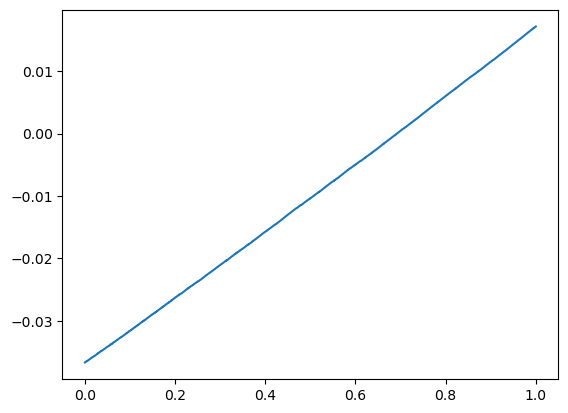

In [276]:
cost = []
for i in range(len(fpr)):
    falsep = fpr[i]
    truep = tpr[i]
    falsen = 1-tp
    truen = 1-fp
    cost.append(-yes_positive*tp*prob_of_fraud - no_negative*tn*prob_of_no_fraud + no_positive*fn*prob_of_fraud + yes_negative*fp*prob_of_no_fraud)


plt.plot(fpr, cost)
plt.show()


In [261]:
#cutoff
print("optimal cutoff for MasterVista is", fpr[np.argmin(cost)])

optimal cutoff for MasterVista is 0.0


## Find 'optimal' cutoff for your GLM

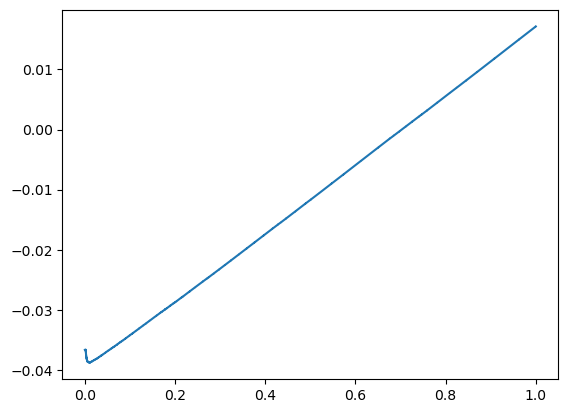

In [278]:
cost2 = []
for i in range(len(fpr2)):
    falsep = fpr2[i]
    treup = tpr2[i]
    falsen = 1-tp
    truen = 1-fp
    cost2.append(-yes_positive*truep*prob_of_fraud - no_negative*truen*prob_of_no_fraud + no_positive*falsen*prob_of_fraud + yes_negative*falsep*prob_of_no_fraud)

plt.plot(fpr2, cost2)
plt.show()


In [279]:
print("optimal cutoff for MasterVista is", fpr2[np.argmin(cost2)])

optimal cutoff for MasterVista is 0.009554165826104499


## Find 'optimal' cutoff for  your tree model

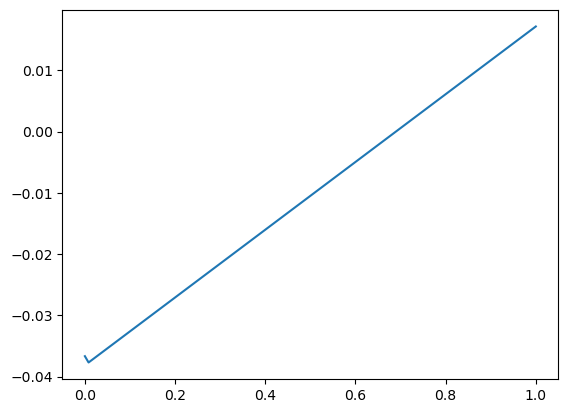

In [307]:
cost3 = []
for i in range(len(fpr3)):
    falsep = fpr3[i]
    truep = tpr3[i]
    falsen = 1-tp
    truen = 1-fp
    cost3.append(-yes_positive*truep*prob_of_fraud - no_negative*truen*prob_of_no_fraud + no_positive*falsen*prob_of_fraud + yes_negative*falsep*prob_of_no_fraud)

plt.plot(fpr3, cost3)
plt.show()


In [309]:
print("optimal cutoff for MasterVista is", fpr3[np.argmin(cost3)])

optimal cutoff for MasterVista is 0.008160177526729876


# <span style="font-family: Palatino; font-size: 30px; color:purple">Estimating economic value of models </span>

## Estimate cost of fraud with no model at optimal cutoff (per dollar loaned)

In [298]:
-yes_positive*tp*real_fraud - no_negative*tn*real_no_fraud + no_positive*fn*real_fraud + yes_negative*fp*real_no_fraud


0.01786

## Estimate cost of fraud with MasterVista's original model at it's optimal cutoff (per dollar loaned)

In [299]:
arg_min = np.argmin(cost)
cost[arg_min]

-0.038760414621592965

## Estimate cost of fraud with your GLM at it's optimal cutoff (per dollar loaned)

In [301]:
arg_min2 = np.argmin(cost2)
cost2[arg_min2]

-0.038760414621592965

## Estimate cost of fraud with with your tree model at it's optimal cutoff (per dollar loaned)

In [300]:
arg_min3 = np.argmin(cost3)
cost3[arg_min3]

-0.03765496705234982

# Summarize costs of each approach

## Create a table that shows (a) the AUC of each model; (b) the optimal cutoff value for each model; and (c) the expected cost per transaction of if each model is used at its optimal cutoff.

| Model       |    AUC   |Optimal cutoff (k)|Cost per $1 loaned|
|------------:|---------:|-----------------:|-----------------:|
| MV original | 0.588212         |        0          |  -0.0387604                |
| my GLM      | 0.859688         |         0.0095541         |  -0.0387604                |
| my tree     |0.646915         |         0.0082126         |    -0.0376549              |

## Which model would you recommend that the bank use to minimize its lending costs? 

Although GLM model is stronger than tree model, I would recommend tree model because it would save the most money.

## If the bank processes 300,000 transactions per day, with an average value of 25 dollars each, how much money would using the new model save the bank versus the current MasterVista model in the first 30 days of deploying the model?

In [316]:
dollar = 25
days = 30
num_trans = 30000

#we'll use tree model as new model
(cost[arg_min] - cost3[arg_min3])*dollar*days*num_trans

24127.90988252155

# <span style="font-family: Palatino; font-size: 30px; color:purple">Ooops! </span>

## Imagine that you now learn that the true rate of fraudulent transactions is 2%.  Recalculate the optimal cutoff for the MasterVista model.

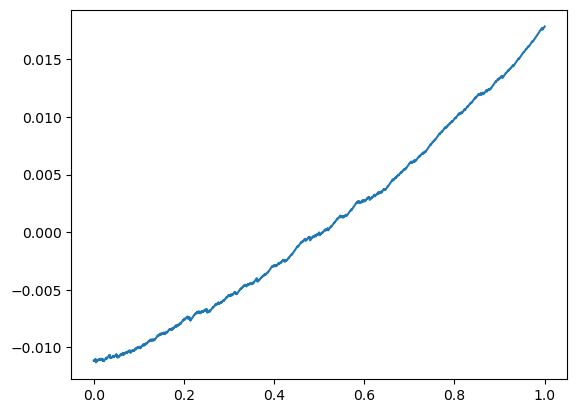

In [195]:
real_fraud = 0.02
real_no_fraud = 1 - real_fraud

cost4 = []
for i in range(len(fpr)):
    falsep = fpr[i]
    truep = tpr[i]
    falsen = 1-tp
    truen = 1-fp
    cost4.append(-yes_positive*truep*real_fraud - no_negative*truen*real_no_fraud + no_positive*falsen*real_fraud + yes_negative*falsep*real_no_fraud)


plt.plot(fpr, cost4)
plt.show()

In [317]:
fpr[np.argmin(cost4)]
print("optimal cutoff for true MasterVista is", fpr[np.argmin(cost4)])

optimal cutoff for true MasterVista is 0.004890054468428485
